In [1]:
import sklearn
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K

%matplotlib inline

TABLE_FILE = "../../data/image_pairs_filtered.csv"
IMAGES_DIR = "../../data/ssd-images/"

csv_data = pd.read_csv(TABLE_FILE, sep=';')

print(csv_data.shape)
print(csv_data.columns)

Using TensorFlow backend.


(88310, 6)
Index(['id_0', 'img_0', 'id_1', 'img_1', 'match', 'job'], dtype='object')


In [2]:
def is_valid_pair(row):
    return os.path.exists(IMAGES_DIR + row['id_0'] + '.jpg') and os.path.exists(IMAGES_DIR + row['id_1'] + '.jpg')


if not os.path.exists('./pair_data.pkl'):
    half = int(csv_data.shape[0] / 2) # I have half of the images downloaded
    csv_data['is_valid'] = csv_data[:half].apply(is_valid_pair, axis=1)
    valid_data = csv_data[csv_data['is_valid'] == True].dropna()
    valid_data.to_pickle('./pair_data.pkl')
    csv_data = valid_data
else:
    csv_data = pd.read_pickle('./pair_data.pkl')


In [3]:
print(csv_data.shape)
print(csv_data.columns)

(37412, 7)
Index(['id_0', 'img_0', 'id_1', 'img_1', 'match', 'job', 'is_valid'], dtype='object')


In [4]:
def data_batch(dframe, batch_size):
#     return dframe[dframe['match'] == True][:batch_size]
    true_sample = dframe[dframe['match'] == True].sample(n=batch_size // 2)
    false_sample = dframe[dframe['match'] == False].sample(n=batch_size // 2)
    
    batch = pd.concat([true_sample, false_sample])
    return batch.sample(frac=1)

def data_batch_flow(dframe, batch_size):
    while True:
        yield data_batch(dframe, batch_size)

In [5]:
def id_to_img(img_id):
    try:
        path = f"{IMAGES_DIR}{img_id}.jpg"
        return img_to_array(load_img(path))
    except Exception as e:
        return None

def row_to_img_pair(row):
    img_0 = id_to_img(row['id_0'])
    img_1 = id_to_img(row['id_1'])
    if img_0 is None or img_1 is None:
        return None, None
    target = 1 if row['match'] == True else 0
    
    return [img_0 / 255, img_1 / 255], target

def batch_to_img_pairs(dframe):
    pairs = []
    targets = []
    for index, row in dframe.iterrows():
        pair, target = row_to_img_pair(row)
        if pair is not None:
            pairs.append(pair)
            targets.append(target)
    
    return np.array(pairs), np.array(targets)

In [6]:
pair_flow = map(batch_to_img_pairs, data_batch_flow(csv_data, 32))

In [7]:
pairs, targets = next(pair_flow)
pair = pairs[0]
img_0 = pair[0]
img_1 = pair[1]
img_0[0][0] # pixel

array([ 1.,  1.,  1.], dtype=float32)

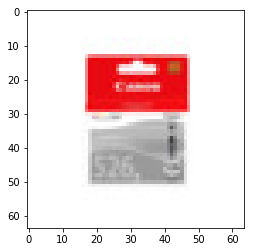

In [8]:
plt.imshow(img_0)

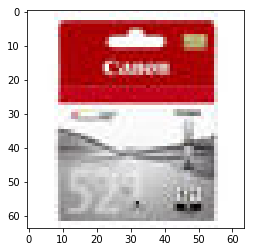

In [9]:
plt.imshow(img_1)

In [10]:
pairs.shape
print(pairs[:,1].shape)
del pair_flow

(32, 64, 64, 3)


In [11]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) +
                  (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [ ]:
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    return Model(input, x)

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))



input_shape = (64, 64, 3)

base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

In [ ]:
# train
tr_pair_flow = map(batch_to_img_pairs, data_batch_flow(csv_data, 32))
te_pair_flow = map(batch_to_img_pairs, data_batch_flow(csv_data, 32))

tr_pair_flow_gen = map(lambda batch: ([batch[0][:,0], batch[0][:,1]], batch[1]), tr_pair_flow)
te_pair_flow_gen = map(lambda batch: ([batch[0][:,0], batch[0][:,1]], batch[1]), te_pair_flow)


rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit_generator(
    tr_pair_flow_gen,
    steps_per_epoch=100,
    epochs=10,
    validation_data=te_pair_flow_gen,
    validation_steps=10,
)

Epoch 1/10
100/100 [==============================] - 33s - loss: 8.8206 - accuracy: 0.5209 - val_loss: 0.4997 - val_accuracy: 0.5000
Epoch 2/10
100/100 [==============================] - 28s - loss: 0.4135 - accuracy: 0.5003 - val_loss: 0.4997 - val_accuracy: 0.5000
Epoch 3/10
100/100 [==============================] - 23s - loss: 0.3408 - accuracy: 0.5022 - val_loss: 0.4997 - val_accuracy: 0.5000
Epoch 4/10
100/100 [==============================] - 25s - loss: 0.3037 - accuracy: 0.4925 - val_loss: 0.4997 - val_accuracy: 0.5000
Epoch 5/10
100/100 [==============================] - 24s - loss: 0.3855 - accuracy: 0.4944 - val_loss: 0.4997 - val_accuracy: 0.5000
Epoch 6/10
100/100 [==============================] - 24s - loss: 0.2810 - accuracy: 0.4978 - val_loss: 0.4997 - val_accuracy: 0.5000
Epoch 7/10
 80/100 [=======================>......] - ETA: 4s - loss: 0.2794 - accuracy: 0.5082

In [ ]:
# compute final accuracy on training and test sets
tr_batch, tr_y = next(tr_pair_flow_gen)
te_batch, te_y = next(te_pair_flow_gen)

y_pred = model.predict_on_batch(tr_batch)
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict(te_batch)
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))